# Building neural networks in NumPy and scikit-learn

# Neural networks

Artificial neural networks are computational systems that can learn to perform tasks by considering examples,
generally without being programmed with any task-specific rules. It is supposed to mimic a biological system, wherein neurons interact by sending signals in the form of mathematical functions between layers. All layers can contain an arbitrary number of neurons, and each connection is represented by a weight variable.  
  
In this tutorial we will build a feed-forward neural network, where information moves in only in direction:
forward through the layers. Each neuron or *node* is represented by a circle, while arrows display the connections
between the nodes and indicate the direction of information flow. Each node in a layer is connected to all nodes in the subsequent layer, which makes this a so-called *fully-connected* feed-forward neural network.

![FFNN](https://upload.wikimedia.org/wikipedia/commons/4/46/Colored_neural_network.svg)  
Via [Wikipedia](https://en.wikipedia.org/wiki/File:Colored_neural_network.svg)

# Prerequisites

To follow this tutorial we require an installation of Python with the numerical package **NumPy**, either:  
1) Python 2.7.x  
2) Python 3.5.x or greater  
  
With a version of NumPy 1.0.x or greater.  
We will also use the packages **matplotlib**, **scikit-learn**, and **Seaborn**, though these are not strictly necessary.  
To run this notebook you also need an installation of **IPython** and **Jupyter Notebook**.  
  
# Anaconda
Anaconda is a free and open source Python and R distribution, that aims to simplify package management and deployment. Anaconda comes with more than 1000 data packages, as well as the Conda package and package and virtual environment manager. Anaconda is available on Linux, OS X and Windows systems, and contains nearly all prerequisite software; it comes highly recommended.  
  
# Pip package manager
If you do not wish to install Anaconda you may download Python from [here](https://www.python.org/downloads/),
or you can use package managers like **brew**, **apt**, **pacman**,...  
Python distributions come with their own package manager, **pip**, and once you have Python installed
you can run the following command:  
  
```pip install numpy matplotlib scikit-learn seaborn ipython jupyter```  

![Python](https://imgs.xkcd.com/comics/python_environment.png)  
Via [xkcd](https://xkcd.com/1987/)

# Workflow
  
One can identify a set of key steps when using neural networks to solve supervised learning problems:  
  
**
1) Collect and pre-process data  
2) Define model and architecture  
3) Choose cost function and optimizer  
4) Train the model  
5) Evaluate model performance on test data  
6) Adjust hyperparameters (if necessary, network architecture)
**

# 1) Collect and pre-process data
  
In this tutorial we will be using the MNIST dataset, which is readily available through the **scikit-learn**
package. You may also find it for example [here](http://yann.lecun.com/exdb/mnist/).  
The **MNIST** (Modified National Institute of Standards and Technology) database is a large database
of handwritten digits that is commonly used for training various image processing systems.  
The MNIST dataset consists of 70 000 images of size 28x28 pixels, each labeled from 0 to 9.  
The scikit-learn dataset we will use consists of a selection of 1797 images from this database.  
  
To feed data into a feed-forward neural network we need to represent the inputs as a feature matrix $X = [n_{inputs}, 
n_{features}]$.  
Each row represents an **input**, in this case a handwritten digit, and each column represents a **feature**, in this case a pixel.  
The correct answers, also known as **labels** or **targets** are represented as a 1D array of integers $Y = [n_{inputs}] = [5, 3, 1, 8,...]$.  
  
Say I wanted to build a neural network using supervised learning to predict Body-Mass Index (BMI) from
measurements of height (in m)  
and weight (in kg). If I had measurements of 5 people the feature matrix could be for example:  
  
$$ X = \begin{bmatrix}
1.85 & 81\\
1.71 & 65\\
1.95 & 103\\
1.55 & 42\\
1.63 & 56
\end{bmatrix} ,$$  
  
and the targets would be:  
  
$$ Y = (23.7, 22.2, 27.1, 17.5, 21.1) $$  
  
Since each input image is a 2D matrix, we need to flatten the image (i.e. "unravel" the 2D matrix into a 1D array)  
to turn the data into a feature matrix. This means we lose all spatial information in the image, such as locality and translational invariance ([explanation](https://stats.stackexchange.com/questions/208936/what-is-translation-invariance-in-computer-vision-and-convolutional-neural-netwo)).  
More complicated architectures such as Convolutional Neural Networks can take advantage
of such information, and are most commonly applied when analyzing images.

inputs = (n_inputs, pixel_width, pixel_height) = (1797, 8, 8)
labels = (n_inputs) = (1797,)
X = (n_inputs, n_features) = (1797, 64)


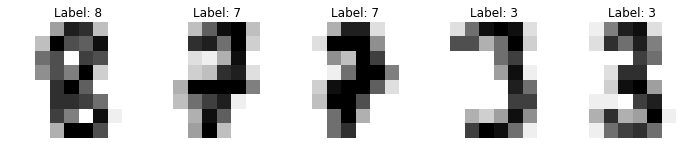

In [1]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets


# ensure the same random numbers appear every time
np.random.seed(0)

# display images in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,12)


# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

print("inputs = (n_inputs, pixel_width, pixel_height) = " + str(inputs.shape))
print("labels = (n_inputs) = " + str(labels.shape))


# flatten the image
# the value -1 means dimension is inferred from the remaining dimensions: 8x8 = 64
n_inputs = len(inputs)
inputs = inputs.reshape(n_inputs, -1)
print("X = (n_inputs, n_features) = " + str(inputs.shape))


# choose some random images to display
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[random_indices[i]])
plt.show()


# Train and test datasets

Performing analysis before partitioning the dataset is a major error, that can lead to incorrect conclusions  
(see "Bias-Variance Tradeoff", for example [here](https://ml.berkeley.edu/blog/2017/07/13/tutorial-4/)).  
  
We will reserve $80 \%$ of our dataset for training and $20 \%$ for testing.  
  
It is important that the train and test datasets are drawn randomly from our dataset, to ensure
no bias in the sampling.  
Say you are taking measurements of weather data to predict the weather in the coming 5 days.
You don't want to train your model on measurements taken from the hours 00.00 to 12.00, and then test it on data
collected from 12.00 to 24.00.

In [2]:
from sklearn.model_selection import train_test_split

# one-liner from scikit-learn library
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)

# equivalently in numpy
def train_test_split_numpy(inputs, labels, train_size, test_size):
    n_inputs = len(inputs)
    inputs_shuffled = inputs.copy()
    labels_shuffled = labels.copy()
    
    np.random.shuffle(inputs_shuffled)
    np.random.shuffle(labels_shuffled)
    
    train_end = int(n_inputs*train_size)
    X_train, X_test = inputs_shuffled[:train_end], inputs_shuffled[train_end:]
    Y_train, Y_test = labels_shuffled[:train_end], labels_shuffled[train_end:]
    
    return X_train, X_test, Y_train, Y_test

#X_train, X_test, Y_train, Y_test = train_test_split_numpy(inputs, labels, train_size, test_size)


# 2) Define model and architecture
  
Our simple feed-forward neural network will consist of an **input** layer, a single **hidden** layer and an **output** layer. The activation $y$ of each neuron is a weighted sum of inputs, passed through an activation function:  
  
$$ z = \sum_{i=1}^n w_i a_i ,$$
  
$$ y = f(z) ,$$
  
where $f$ is the activation function, $a_i$ represents input from neuron $i$ in the preceding layer
and $w_i$ is the weight to input $i$.  
The activation of the neurons in the input layer is just the features (e.g. a pixel value).  
  
The simplest activation function for a neuron is the **Heaviside** function:
  
$$ f(z) = 
\begin{cases}
1,  &  z > 0\\
0,  & \text{otherwise}
\end{cases}
$$
  
A feed-forward neural network with this activation is known as a **perceptron**.  
For a binary classifier (i.e. two classes, 0 or 1, dog or not-dog) we can also use this in our output layer.  
This activation can be generalized to $k$ classes (using e.g. the *one-against-all* strategy), 
and we call these architectures **multiclass perceptrons**.  
  
However, it is now common to use the terms Single Layer Perceptron (SLP) (1 hidden layer) and  
Multilayer Perceptron (MLP) (2 or more hidden layers) to refer to feed-forward neural networks with any activation function.  
  
Typical choices for activation functions include the sigmoid function, hyperbolic tangent, and Rectified Linear Unit (ReLU).  
We will be using the sigmoid function $\sigma(x)$:  
  
$$ f(x) = \sigma(x) = \frac{1}{1 + e^{-x}} ,$$
  
which is inspired by probability theory (see logistic regression) and was most commonly used until about 2011.
  
# Layers
  
**Input**:  
Since each input image has 8x8 = 64 pixels or features, we have an input layer of 64 neurons.  
  
**Hidden layer**:  
We will use 50 neurons in the hidden layer receiving input from the neurons in the input layer.  
Since each neuron in the hidden layer is connected to the 64 inputs we have 64x50 = 3200 weights to the hidden layer.  
  
**Output**:  
If we were building a binary classifier, it would be sufficient with a single neuron in the output layer,
which could output 0 or 1 according to the Heaviside function. This would be an example of a **hard** classifier, meaning it outputs the class of the input directly. However, if we are dealing with noisy data it is often beneficial to use a **soft** classifier, which outputs the probability of being in class 0 or 1.  
  
For a soft binary classifier, we could use a single neuron and interpret the output as either being the probability of being in class 0 or the probability of being in class 1. Alternatively we could use 2 neurons, and interpret each neuron as the probability of being in each class.  
  
Since we are doing multiclass classification, with 10 categories, it is natural to use 10 neurons in the output layer. We number the neurons $j = 0,1,...,9$. The activation of each output neuron $j$ will be according to the **softmax** function:  
  
$$ P(\text{class $j$} \mid \text{input $\boldsymbol{a}$}) = \frac{\exp{(\boldsymbol{a}^T \boldsymbol{w}_j)}}
{\sum_{c=0}^{9} \exp{(\boldsymbol{a}^T \boldsymbol{w}_c)}} ,$$  
  
i.e. each neuron $j$ outputs the probability of being in class $j$ given an input from the hidden layer $\boldsymbol{a}$, with $\boldsymbol{w}_j$ the weights of neuron $j$ to the inputs.  
The denominator is a normalization factor to ensure the outputs sum up to 1.  
The exponent is just the weighted sum of inputs as before:  
  
$$ z_j = \sum_{i=1}^n w_ {ij} a_i = \boldsymbol{a}^T \boldsymbol{w}_j .$$  
  
Since each neuron in the output layer is connected to the 50 inputs from the hidden layer we have 50x10 = 500
weights to the output layer.
  
# Weights and biases
  
Typically weights are initialized with small values distributed around zero, drawn from a uniform
or normal distribution. Setting all weights to zero means all neurons give the same output, making the network useless.  
  
Adding a bias value to the weighted sum of inputs allows the neural network to represent a greater range
of values. Without it, any input with the value 0 will be mapped to zero (before being passed through the activation). The bias unit has an output of 1, and a weight to each neuron $j$, $b_j$:  
  
$$ z_j = \sum_{i=1}^n w_ {ij} a_i + 1\cdot b_j = \boldsymbol{a}^T \boldsymbol{w}_j + b_j .$$  
  
The bias weights $\boldsymbol{b}$ are often initialized to zero, but a small value like $0.01$ ensures all neurons have some output which can be backpropagated in the first training cycle.

![Bias](http://ufldl.stanford.edu/tutorial/images/Network331.png)  
Via [Stanford UFLDL](http://ufldl.stanford.edu/tutorial/supervised/MultiLayerNeuralNetworks/)

In [3]:
# building our neural network

n_inputs, n_features = X_train.shape
n_hidden_neurons = 50
n_categories = 10

# we make the weights normally distributed using numpy.random.randn

# weights and bias in the hidden layer
hidden_weights = np.random.randn(n_features, n_hidden_neurons)
hidden_bias = np.zeros(n_hidden_neurons) + 0.01

# weights and bias in the output layer
output_weights = np.random.randn(n_hidden_neurons, n_categories)
output_bias = np.zeros(n_categories) + 0.01

# Feed-forward pass

Denote $F$ the number of features, $H$ the number of hidden neurons and $C$ the number of categories.  
For each input image we calculate a weighted sum of input features (pixel values) to each neuron $j$ in the hidden layer:  
  
$$ z_{j}^{h} = \sum_{i=1}^{F} w_{ij}^{h} x_i + b_{j}^{h} = \boldsymbol{x}^T \boldsymbol{w}_{j}^{h} + b_{j}^{h} ,$$
  
this is then passed through our activation function  
  
$$ a_{j}^{h} = f(z_{j}^{h}) .$$  
  
We calculate a weighted sum of inputs (activations in the hidden layer) to each neuron $j$ in the output layer:  
  
$$ z_{j}^{o} = \sum_{i=1}^{H} w_{ij}^{o} a_{i}^{h} + b_{j}^{o} = (\boldsymbol{a}^{h})^T \boldsymbol{w}_{j}^{o} + b_{j}^{o} .$$  
  
Finally we calculate the output of neuron $j$ in the output layer using the softmax function:  
  
$$ a_{j}^{o} = \frac{\exp{(z_j^{o})}}
{\sum_{c=0}^{C-1} \exp{(z_c^{o})}} .$$  
   
# Matrix multiplication
  
Since our data has the dimensions $X = (n_{inputs}, n_{features})$ and our weights to the hidden
layer have the dimensions  
$W_{hidden} = (n_{features}, n_{hidden})$,
we can easily feed the network all our training data in one go by taking the matrix product  
  
$$ X W^{h} = (n_{inputs}, n_{hidden}),$$ 
  
and obtain a matrix that holds the weighted sum of inputs to the hidden layer
for each input image and each hidden neuron.    
We also add the bias to obtain a matrix of weighted sums $Z^{h}$:  
  
$$ Z^{h} = X W^{h} + B^{h} ,$$
  
meaning the same bias (1D array) is added to each input image.  
This is then passed through the activation  
  
$$ A^{h} = f(Z^h) .$$  
  
This is fed to the output layer:  
  
$$ Z^{o} = A^{h} W^{o} + B^{o} .$$
  
Finally we receive our output values for each image and each category by passing it through the softmax function:  
  
$$ output = softmax (Z^{o}) = (n_{inputs}, n_{categories}) .$$

In [4]:
# setup the feed-forward pass

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def feed_forward(X):
    # weighted sum of inputs to the hidden layer
    z_h = np.matmul(X, hidden_weights) + hidden_bias
    # activation in the hidden layer
    a_h = sigmoid(z_h)
    
    # weighted sum of inputs to the output layer
    z_o = np.matmul(a_h, output_weights) + output_bias
    # softmax output
    # axis 0 holds each input and axis 1 the probabilities of each category
    exp_term = np.exp(z_o)
    probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
    
    return probabilities

probabilities = feed_forward(X_train)
print("probabilities = (n_inputs, n_categories) = " + str(probabilities.shape))
print("probability that image 0 is in category 0,1,2,...,9 = \n" + str(probabilities[0]))
print("probabilities sum up to: " + str(probabilities[0].sum()))
print()

# we obtain a prediction by taking the class with the highest likelihood
def predict(X):
    probabilities = feed_forward(X)
    return np.argmax(probabilities, axis=1)

predictions = predict(X_train)
print("predictions = (n_inputs) = " + str(predictions.shape))
print("prediction for image 0: " + str(predictions[0]))
print("correct label for image 0: " + str(Y_train[0]))

probabilities = (n_inputs, n_categories) = (1437, 10)
probability that image 0 is in category 0,1,2,...,9 = 
[5.41511965e-04 2.17174962e-03 8.84355903e-03 1.44970586e-03
 1.10378326e-04 5.08318298e-09 2.03256632e-04 1.92507116e-03
 9.84443254e-01 3.11507992e-04]
probabilities sum up to: 1.0

predictions = (n_inputs) = (1437,)
prediction for image 0: 8
correct label for image 0: 6


# 3) Choose cost function and optimizer
  
To measure how well our neural network is doing we need to introduce a cost function.  
We will call the function that gives the error of a single sample output the **loss** function, and the function
that gives the total error of our network across all samples the **cost** function.
A typical choice for multiclass classification is the **cross-entropy** loss, also known as the negative log likelihood.  
In multiclass classification it is common to treat each integer label as a so called **one-hot** vector:  
  
$$ y = 5 \quad \rightarrow \quad \boldsymbol{y} = (0, 0, 0, 0, 0, 1, 0, 0, 0, 0) ,$$  

  
$$ y = 1 \quad \rightarrow \quad \boldsymbol{y} = (0, 1, 0, 0, 0, 0, 0, 0, 0, 0) ,$$  
  
  
i.e. a binary bit string of length $K$, where $K = 10$ is the number of classes.  
  
If $\boldsymbol{x}$ is an input (image), $y_{k}$ refers to the $k$-th component of the
output vector $\boldsymbol{y}$.  
The probability of $\boldsymbol{x}$ being in class $k$ is given by the softmax function:  
  
$$ P(y_{k} = 1 \mid \boldsymbol{x}, \boldsymbol{\theta}) = \frac{\exp{((\boldsymbol{a}^{hidden})^T \boldsymbol{w}_k)}}
{\sum_{c=0}^{C-1} \exp{((\boldsymbol{a}^{hidden})^T \boldsymbol{w}_{c})}} ,$$
  
where $\boldsymbol{a}^{hidden}$ is the activation in the hidden layer from input $\boldsymbol{x}$.
The vector $\boldsymbol{\theta}$ represents the weights and biases of our network.  
The probability of not being in class $k$ is just $1 - P(y_{k} = 1 \mid \boldsymbol{x}, \boldsymbol{\theta})$.  
  
For Maximum Likelihood Estimation (MLE) we maximize the likelihood of observing the correct output
for each input.  
Denote the output $\hat{\boldsymbol{y}}$ and the correct labels $\boldsymbol{y}$.
The likelihood that input $\boldsymbol{x}$ gives a correct output $y = k$ is then
  
$$ P(y = k \mid \boldsymbol{x}, \boldsymbol{\theta}) = \prod_{c=0}^{C-1} [P(y_{c} = 1 \mid \boldsymbol{x}, \boldsymbol{\theta})]^{y_{c}} 
\times [1 - P(y_{c} = 1 \mid \boldsymbol{x}, \boldsymbol{\theta})]^{1-y_{c}} ,$$  
  
where $y_c$ is the $c$-th component of the one-hot vector of (correct) labels.  
A perfect classifier should give a $100 \%$ probability of the correct label, so the product
should just be 1 if $y = k$ and 0 otherwise. If the network is not a perfect classifier, the likelihood should be a number between 0 and 1.  
  
If we take the log of this we can turn the product into a sum, which is often simpler to compute:  
  
$$ \log P(y = k \mid \boldsymbol{x}, \boldsymbol{\theta}) = \sum_{c=0}^{C-1} y_{c} \log P(y_{c} = 1 \mid \boldsymbol{x}, \boldsymbol{\theta}) 
+ (1-y_{c})\log (1 - P(y_{c} = 1 \mid \boldsymbol{x}, \boldsymbol{\theta}))$$  
  
For a perfect classifier this should just be $\log 1 = 0$. Otherwise we get a negative number.  
  
Since it is easier to think in terms of minimizing a positive number, we take our loss function
to be the negative log-likelihood:  
  
$$ \mathcal{L}(\boldsymbol{\theta}) = - \log P(y = k \mid \boldsymbol{x}, \boldsymbol{\theta}) .$$  
  
We then take the average of the loss function over all input samples to define the cost function:  
$$ \begin{split} \mathcal{C}(\boldsymbol{\theta}) &= \frac{1}{N} \sum_{i=1}^N \mathcal{L}(\boldsymbol{w}) \\
 &= -\frac{1}{N}\sum_{i=1}^N \sum_{c=0}^{C-1} y_{c} \log P(y_{c} = 1 \mid \boldsymbol{x}, \boldsymbol{\theta}) 
+ (1-y_{c})\log (1 - P(y_{c} = 1 \mid \boldsymbol{x}, \boldsymbol{\theta})) \end{split} .$$
  
# Optimizing the cost function
  
The network is trained by finding the weights and biases that minimize the cost function. One of the most widely used classes of methods is **gradient descent** and its generalizations. The idea behind gradient descent
is simply to adjust the weights in the direction where the gradient of the cost function is large and negative. This ensures we flow toward a **local** minimum of the cost function.  
Each parameter $\theta$ is iteratively adjusted according to the rule  
  
$$ \theta_{i+1} = \theta_i - \eta \nabla \mathcal{C}(\theta_i) ,$$

where $\eta$ is known as the **learning rate**, which controls how big a step we take towards the minimum.  
This update can be repeated for any number of iterations, or until we are satisfied with the result.  
  
A simple and effective improvement is a variant called **Batch Gradient Descent**.  
Instead of calculating the gradient on the whole dataset, we calculate an approximation of the gradient
on a subset of the data called a **minibatch**.  
If there are $N$ data points and we have a minibatch size of $M$, the total number of batches
is $n/M$.  
We denote each minibatch $B_k$, with $k = 1, 2,...,n/M$. The gradient then becomes:  
  
$$ \nabla \mathcal{C}(\theta) = \frac{1}{N} \sum_{i=1}^N \nabla \mathcal{L}(\theta) \quad \rightarrow \quad
\frac{1}{M} \sum_{i \in B_k} \nabla \mathcal{L}(\theta) ,$$
  
i.e. instead of averaging the loss over the entire dataset, we average over a minibatch.  
  
This has two important benefits:  
1) Introducing stochasticity decreases the chance that the algorithm becomes stuck in a local minima.  
2) It significantly speeds up the calculation, since we do not have to use the entire dataset to calculate the gradient.  
  
# Regularization
  
It is common to add an extra term to the cost function, proportional to the size of the weights.  
This is equivalent to constraining the size of the weights, so that they do not grow out of control.  
Constraining the size of the weights means that the weights cannot grow arbitrarily large to fit the training data, and in this way reduces overfitting.  
  
We will measure the size of the weights using the so called **L2-norm**, meaning our cost function becomes:  
  
$$ \nabla \mathcal{C}(\theta) = \frac{1}{N} \sum_{i=1}^N \nabla \mathcal{L}(\theta) \quad \rightarrow \quad
\frac{1}{N} \sum_{i=1}^N \nabla \mathcal{L}(\theta) + \lambda \lvert \lvert \boldsymbol{w} \rvert \rvert_2^2 
= \frac{1}{N} \sum_{i=1}^N \nabla \mathcal{L}(\theta) + \lambda \sum_{ij} w_{ij}^2,$$  
  
i.e. we sum up all the weights squared. The factor $\lambda$ is known as a regularization parameter.

# 4) Train the model
  
In order to train the model, we need to calculate the derivative of the cost function with respect
to every bias and weight in the network. Using an approximation to the derivative (e.g. using the [finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method)) is much too costly.  
In total our network has $(64 + 1) \times 50 = 3250$ weights in the hidden layer and $(50 + 1) \times 10 = 510$ weights to the output layer ($ + 1$ for the bias), and the gradient must be calculated for every parameter.  
  
The **backpropagation** algorithm is a clever use of the chain rule that allows us to calculate the gradient efficently. Here we will simply state the backpropagation equations that we will use for our network, and then a derivation is given at the end of this tutorial.  
  
The error $\delta_i^o$ at each output neuron $i$ is just the difference between the output probability $\hat{y}_i$ and the correct label $y_i$ (0 or 1 using one-hot vectors):  
  
$$ \delta_i^o = \hat{y}_i - y_i .$$  
  
The gradient of the cost function with respect to each output weight $w_{i,j}^o$ is then  
  
$$ \frac{\partial \mathcal{C}}{\partial w_{i,j}^o} = \delta_i^o a_j^h ,$$
  
where $a_j^h$ is the activation at the $j$-th neuron in the hidden layer.  
The gradient with respect to each output bias $b_i^o$ is  
  
$$ \frac{\partial \mathcal{C}}{\partial b_i^o} = \delta_i^o .$$  
  
The error at each hidden layer neuron $\delta_i^h$ is given as  
  
$$ \delta_i^h = \sum_{c=0}^{C-1} \delta_c^o w_{ci}^o \, f'(z_i^h) ,$$
  
where $C$ is the number of output neurons or categories and $f'(z_i^h)$ is the derivative of the activation function:  
  
$$ f'(z_i^h) = \sigma '(z_i^h) = \sigma(z_i^h)(1 - \sigma(z_i^h)) = a_i^h (1 - a_i^h) ,$$
  
since our activation function is the sigmoid/logistic function.  
The gradient with respect to each hidden layer weight is:  
  
$$ \frac{\partial \mathcal{C}}{\partial w_{i,j}^h} = \delta_i^h x_j ,$$  
  
and the gradient with respect to the hidden bias  
  
$$ \frac{\partial \mathcal{C}}{\partial b_i^h} = \delta_i^h .$$  
  
The regularization terms using the L2-norm are just  
  
$$ \frac{\partial }{\partial w_{ij}} (\lambda \sum_{ij} w_{ij}^2) = 2 \lambda w_{ij} = \hat{\lambda} w_{ij} ,$$
  
for the weights in both the output and hidden layers.  
The factor 2 can be absorbed into the regularization parameter, since we have to test for the
optimal value anyway.
  
# Matrix  multiplication
  
To more efficently train our network these equations are implemented using matrix operations.  
The error in the output layer is calculated simply as  
  
$$ \delta_o = \hat{y} - y = (n_{inputs}, n_{categories}) .$$  
  
The gradient for the output weights is calculated as  
  
$$ \nabla W_{o} = A^T \delta_o = (n_{hidden}, n_{categories}) ,$$
  
where $A = (n_{inputs}, n_{hidden})$. This simply means that we are summing up the gradients for each input.  
Since we are going backwards we have to transpose the activation matrix.  
  
The gradient with respect to the output bias is then  
  
$$ \nabla B_{o} = \sum_{i=1}^{n_{inputs}} \delta_o = (n_{categories}) .$$  
  
The error in the hidden layer is  
  
$$ \delta_h = \delta_o W_{o}^T \circ f'(Z_{h}) = \delta_o W_{o}^T \circ A_{h} \circ (1 - A_{h}) = (n_{inputs}, n_{hidden}) ,$$  
  
where $f'(A_{h})$ is the derivative of the activation in the hidden layer. The matrix products means
that we are summing up the products for each neuron in the output layer. The symbol $\circ$ denotes
the **Hadamard** product, meaning element-wise multiplication.  
  
This again gives us the gradients in the hidden layer:  
  
$$ \nabla W_{h} = X^T \delta_h = (n_{features}, n_{hidden}) ,$$  
  
$$ \nabla B_{h} = \sum_{i=1}^{n_{inputs}} \delta_h = (n_{hidden}) .$$

In [5]:
# to categorical turns our integer vector into a onehot representation
from keras.utils import to_categorical
# calculate the accuracy score of our model
from sklearn.metrics import accuracy_score

Y_train_onehot, Y_test_onehot = to_categorical(Y_train), to_categorical(Y_test)

# equivalently in numpy
def to_categorical_numpy(integer_vector):
    n_inputs = len(integer_vector)
    n_categories = np.max(integer_vector) + 1
    onehot_vector = np.zeros((n_inputs, n_categories))
    onehot_vector[range(n_inputs), integer_vector] = 1
    
    return onehot_vector

#Y_train_onehot, Y_test_onehot = to_categorical_numpy(Y_train), to_categorical_numpy(Y_test)

def feed_forward_train(X):
    # weighted sum of inputs to the hidden layer
    z_h = np.matmul(X, hidden_weights) + hidden_bias
    # activation in the hidden layer
    a_h = sigmoid(z_h)
    
    # weighted sum of inputs to the output layer
    z_o = np.matmul(a_h, output_weights) + output_bias
    # softmax output
    # axis 0 holds each input and axis 1 the probabilities of each category
    exp_term = np.exp(z_o)
    probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
    
    # for backpropagation need activations in hidden and output layers
    return a_h, probabilities

def backpropagation(X, Y):
    a_h, probabilities = feed_forward_train(X)
    
    # error in the output layer
    error_output = probabilities - Y
    # error in the hidden layer
    error_hidden = np.matmul(error_output, output_weights.T) * a_h * (1 - a_h)
    
    # gradients for the output layer
    output_weights_gradient = np.matmul(a_h.T, error_output)
    output_bias_gradient = np.sum(error_output, axis=0)
    
    # gradient for the hidden layer
    hidden_weights_gradient = np.matmul(X.T, error_hidden)
    hidden_bias_gradient = np.sum(error_hidden, axis=0)

    return output_weights_gradient, output_bias_gradient, hidden_weights_gradient, hidden_bias_gradient

print("Old accuracy on training data: " + str(accuracy_score(predict(X_train), Y_train)))

eta = 0.01
lmbd = 0.01
for i in range(1000):
    # calculate gradients
    dWo, dBo, dWh, dBh = backpropagation(X_train, Y_train_onehot)
    
    # regularization term gradient
    dWo += lmbd * output_weights
    dWh += lmbd * hidden_weights
    
    # update weights and biases
    output_weights -= eta * dWo
    output_bias -= eta * dBo
    hidden_weights -= eta * dWh
    hidden_bias -= eta * dBh

print("New accuracy on training data: " + str(accuracy_score(predict(X_train), Y_train)))

Using TensorFlow backend.


Old accuracy on training data: 0.1440501043841336
New accuracy on training data: 0.10368823938761308


# Improving performance
  
As we can see the network does not seem to be learning at all. It seems to be just guessing the label for each image.  
In order to obtain a network that does something useful, we will have to do a bit more work.  
  
The choice of **hyperparameters** such as learning rate and regularization parameter is hugely influential for the performance of the network. Typically a **grid-search** is performed, wherein we test different hyperparameters separated by orders of magnitude. For example we could test the learning rates $\eta = 10^{-6}, 10^{-5},...,10^{-1}$ with different regularization parameters $\lambda = 10^{-6},...,10^{-0}$.  
Next, we haven't implemented minibatching yet, which introduces stochasticity and is though to act as an important regularizer on the weights. We call a feed-forward + backward pass with a minibatch an **iteration**, and a full training period
going through the entire dataset ($n/M$ batches) an **epoch**.
  
If this does not improve network performance, you may want to consider altering the network architecture, adding more neurons or hidden layers. Andrew Ng goes through some of these considerations in this [video](https://youtu.be/F1ka6a13S9I). You can find a summary of the video [here](https://kevinzakka.github.io/2016/09/26/applying-deep-learning/).  
  
# Full object-oriented implementation
  
It is very natural to think of the network as an object, with specific instances of the network
being realizations of this object with different hyperparameters. An implementation using Python classes provides a clean structure and interface, and the full implementation of our neural network is given below.

In [6]:
class NeuralNetwork:
    def __init__(
        self,
        X_data,
        Y_data,
        n_hidden_neurons=50,
        n_categories=10,
        epochs=10,
        batch_size=100,
        eta=0.1,
        lmbd=0.0,

    ):
        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        self.n_hidden_neurons = n_hidden_neurons
        self.n_categories = n_categories

        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd

        self.create_biases_and_weights()

    def create_biases_and_weights(self):
        self.hidden_weights = np.random.randn(self.n_features, self.n_hidden_neurons)
        self.hidden_bias = np.zeros(self.n_hidden_neurons) + 0.01

        self.output_weights = np.random.randn(self.n_hidden_neurons, self.n_categories)
        self.output_bias = np.zeros(self.n_categories) + 0.01

    def feed_forward(self):
        # feed-forward for training
        self.z_h = np.matmul(self.X_data, self.hidden_weights) + self.hidden_bias
        self.a_h = sigmoid(self.z_h)

        self.z_o = np.matmul(self.a_h, self.output_weights) + self.output_bias

        exp_term = np.exp(self.z_o)
        self.probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)

    def feed_forward_out(self, X):
        # feed-forward for output
        z_h = np.matmul(X, self.hidden_weights) + self.hidden_bias
        a_h = sigmoid(z_h)

        z_o = np.matmul(a_h, self.output_weights) + self.output_bias
        
        exp_term = np.exp(z_o)
        probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        return probabilities

    def backpropagation(self):
        error_output = self.probabilities - self.Y_data
        error_hidden = np.matmul(error_output, self.output_weights.T) * self.a_h * (1 - self.a_h)

        self.output_weights_gradient = np.matmul(self.a_h.T, error_output)
        self.output_bias_gradient = np.sum(error_output, axis=0)

        self.hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
        self.hidden_bias_gradient = np.sum(error_hidden, axis=0)

        if self.lmbd > 0.0:
            self.output_weights_gradient += self.lmbd * self.output_weights
            self.hidden_weights_gradient += self.lmbd * self.hidden_weights

        self.output_weights -= self.eta * self.output_weights_gradient
        self.output_bias -= self.eta * self.output_bias_gradient
        self.hidden_weights -= self.eta * self.hidden_weights_gradient
        self.hidden_bias -= self.eta * self.hidden_bias_gradient

    def predict(self, X):
        probabilities = self.feed_forward_out(X)
        return np.argmax(probabilities, axis=1)

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]

                self.feed_forward()
                self.backpropagation()


# 5) Evaluate model performance on test data
  
To measure the performance of our network we evaluate how well it does it data it has never seen before, i.e. the test data.  
We measure the performance of the network using the **accuracy** score.  
The accuracy is as you would expect just the number of images correctly labeled divided by the total number of images. A perfect classifier will have an accuracy score of $1$.  
  
$$ \text{Accuracy} = \frac{\sum_{i=1}^n I(\hat{y}_i = y_i)}{n} ,$$  
  
where $I$ is the indicator function, $1$ if $\hat{y}_i = y$ and $0$ otherwise.

In [7]:
epochs = 100
batch_size = 100

dnn = NeuralNetwork(X_train, Y_train_onehot, eta=eta, lmbd=lmbd, epochs=epochs, batch_size=batch_size,
                    n_hidden_neurons=n_hidden_neurons, n_categories=n_categories)
dnn.train()
test_predict = dnn.predict(X_test)

# accuracy score from scikit library
print("Accuracy score on test set: ", accuracy_score(Y_test, test_predict))

# equivalent in numpy
def accuracy_score_numpy(Y_test, Y_pred):
    return np.sum(Y_test == Y_pred) / len(Y_test)

#print("Accuracy score on test set: ", accuracy_score_numpy(Y_test, test_predict))

Accuracy score on test set:  0.9527777777777777


# 6) Adjust hyperparameters (if necessary, network architecture)
  
We now perform the grid search to find the optimal hyperparameters for the network.  
Note that we are only using 1 layer with 50 neurons, and human performance is estimated to be around $98 \%$ ($2 \%$ error rate).

In [8]:
eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)


In [9]:
# store the models for later use
DNN_numpy = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)

# grid search
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = NeuralNetwork(X_train, Y_train_onehot, eta=eta, lmbd=lmbd, epochs=epochs, batch_size=batch_size,
                            n_hidden_neurons=n_hidden_neurons, n_categories=n_categories)
        dnn.train()
        
        DNN_numpy[i][j] = dnn
        
        test_predict = dnn.predict(X_test)
        
        print("Learning rate  = ", eta)
        print("Lambda = ", lmbd)
        print("Accuracy score on test set: ", accuracy_score(Y_test, test_predict))
        print()

Learning rate  =  1e-05
Lambda =  1e-05
Accuracy score on test set:  0.11666666666666667

Learning rate  =  1e-05
Lambda =  0.0001
Accuracy score on test set:  0.20833333333333334

Learning rate  =  1e-05
Lambda =  0.001
Accuracy score on test set:  0.12222222222222222

Learning rate  =  1e-05
Lambda =  0.01
Accuracy score on test set:  0.14722222222222223

Learning rate  =  1e-05
Lambda =  0.1
Accuracy score on test set:  0.17777777777777778

Learning rate  =  1e-05
Lambda =  1.0
Accuracy score on test set:  0.16111111111111112

Learning rate  =  1e-05
Lambda =  10.0
Accuracy score on test set:  0.20277777777777778

Learning rate  =  0.0001
Lambda =  1e-05
Accuracy score on test set:  0.5305555555555556

Learning rate  =  0.0001
Lambda =  0.0001
Accuracy score on test set:  0.5944444444444444

Learning rate  =  0.0001
Lambda =  0.001
Accuracy score on test set:  0.5888888888888889

Learning rate  =  0.0001
Lambda =  0.01
Accuracy score on test set:  0.6111111111111112

Learning rate  

/home/andreas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


Learning rate  =  1.0
Lambda =  1e-05
Accuracy score on test set:  0.07777777777777778

Learning rate  =  1.0
Lambda =  0.0001
Accuracy score on test set:  0.07777777777777778

Learning rate  =  1.0
Lambda =  0.001
Accuracy score on test set:  0.07777777777777778

Learning rate  =  1.0
Lambda =  0.01
Accuracy score on test set:  0.07777777777777778

Learning rate  =  1.0
Lambda =  0.1
Accuracy score on test set:  0.07777777777777778

Learning rate  =  1.0
Lambda =  1.0
Accuracy score on test set:  0.125

Learning rate  =  1.0
Lambda =  10.0
Accuracy score on test set:  0.07777777777777778

Learning rate  =  10.0
Lambda =  1e-05
Accuracy score on test set:  0.07777777777777778

Learning rate  =  10.0
Lambda =  0.0001
Accuracy score on test set:  0.07777777777777778

Learning rate  =  10.0
Lambda =  0.001
Accuracy score on test set:  0.07777777777777778

Learning rate  =  10.0
Lambda =  0.01
Accuracy score on test set:  0.07777777777777778

Learning rate  =  10.0
Lambda =  0.1
Accuracy s

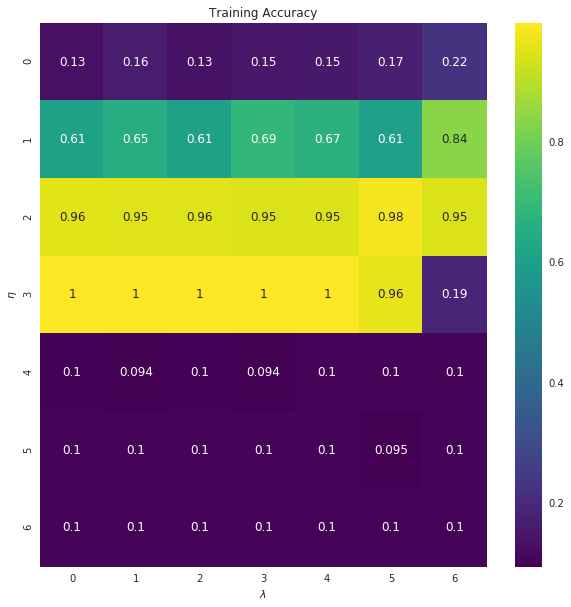

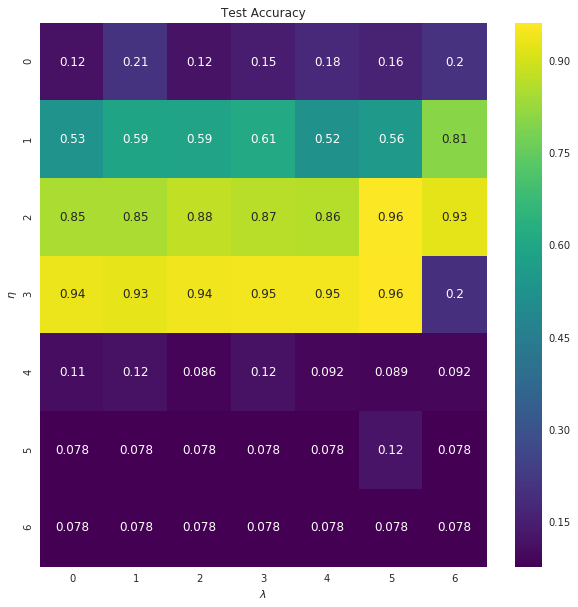

In [10]:
# optional
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        dnn = DNN_numpy[i][j]
        
        train_pred = dnn.predict(X_train) 
        test_pred = dnn.predict(X_test)

        train_accuracy[i][j] = accuracy_score(Y_train, train_pred)
        test_accuracy[i][j] = accuracy_score(Y_test, test_pred)

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()


# scikit-learn implementation
  
scikit-learn is a machine learning library for Python. It focuses more on traditional machine learning methods, such as regression, clustering, decision trees, etc. As such, it has only two types of neural networks, Multi Layer Perceptron outputting continuous values, **MPLRegressor**, and Multi Layer Perceptron outputting labels, **MLPClassifier**. We will see how simple it is to use these classes.  
  
scikit-learn implements a few improvements from our neural network, such as early stopping, a varying learning rate, different optimization methods, etc. We would therefore expect a better performance overall.

In [11]:
from sklearn.neural_network import MLPClassifier

# store models for later use
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)

for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPClassifier(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs)
        dnn.fit(X_train, Y_train)
        
        DNN_scikit[i][j] = dnn
        
        print("Learning rate  = ", eta)
        print("Lambda = ", lmbd)
        print("Accuracy score on test set: ", dnn.score(X_test, Y_test))
        print()

/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  1e-05
Accuracy score on test set:  0.18333333333333332



/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  0.0001
Accuracy score on test set:  0.18611111111111112



/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  0.001
Accuracy score on test set:  0.13055555555555556



/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  0.01
Accuracy score on test set:  0.24444444444444444



/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  0.1
Accuracy score on test set:  0.23333333333333334



/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  1.0
Accuracy score on test set:  0.12777777777777777



/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  10.0
Accuracy score on test set:  0.1527777777777778



/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  1e-05
Accuracy score on test set:  0.9111111111111111



/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  0.0001
Accuracy score on test set:  0.8888888888888888



/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  0.001
Accuracy score on test set:  0.8722222222222222



/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  0.01
Accuracy score on test set:  0.8305555555555556



/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  0.1
Accuracy score on test set:  0.8888888888888888



/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  1.0
Accuracy score on test set:  0.8805555555555555



/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  10.0
Accuracy score on test set:  0.8944444444444445



/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  1e-05
Accuracy score on test set:  0.975



/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  0.0001
Accuracy score on test set:  0.9777777777777777



/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  0.001
Accuracy score on test set:  0.9805555555555555



/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  0.01
Accuracy score on test set:  0.9861111111111112



/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  0.1
Accuracy score on test set:  0.9805555555555555



/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  1.0
Accuracy score on test set:  0.9777777777777777

Learning rate  =  0.001
Lambda =  10.0
Accuracy score on test set:  0.9444444444444444

Learning rate  =  0.01
Lambda =  1e-05
Accuracy score on test set:  0.9861111111111112

Learning rate  =  0.01
Lambda =  0.0001
Accuracy score on test set:  0.9888888888888889

Learning rate  =  0.01
Lambda =  0.001
Accuracy score on test set:  0.9805555555555555

Learning rate  =  0.01
Lambda =  0.01
Accuracy score on test set:  0.9861111111111112

Learning rate  =  0.01
Lambda =  0.1
Accuracy score on test set:  0.9833333333333333

Learning rate  =  0.01
Lambda =  1.0
Accuracy score on test set:  0.9694444444444444

Learning rate  =  0.01
Lambda =  10.0
Accuracy score on test set:  0.9583333333333334

Learning rate  =  0.1
Lambda =  1e-05
Accuracy score on test set:  0.9

Learning rate  =  0.1
Lambda =  0.0001
Accuracy score on test set:  0.8694444444444445

Learning rate  =  0.1
Lambda =  0.001
Accuracy score o

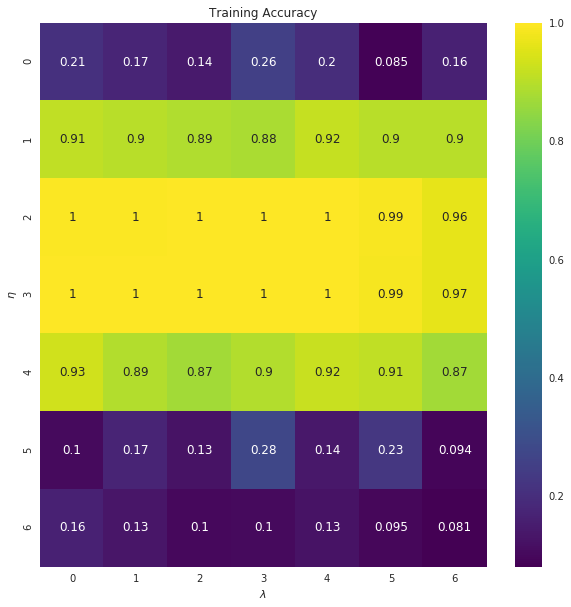

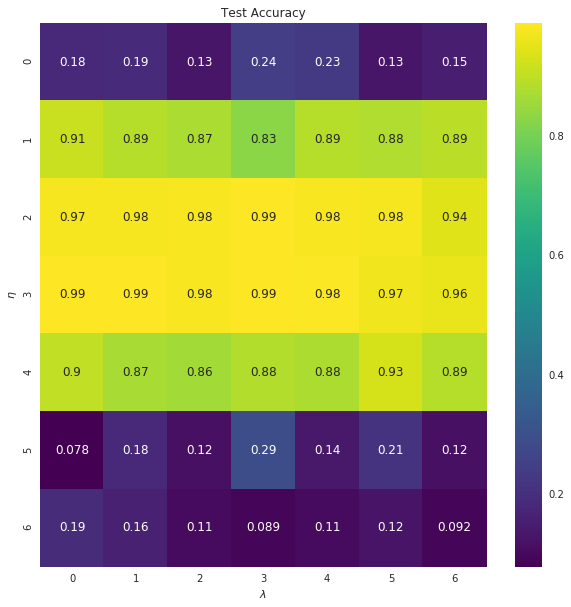

In [12]:
# optional
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        dnn = DNN_scikit[i][j]
        
        train_pred = dnn.predict(X_train) 
        test_pred = dnn.predict(X_test)

        train_accuracy[i][j] = accuracy_score(Y_train, train_pred)
        test_accuracy[i][j] = accuracy_score(Y_test, test_pred)

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()


# Appendix

# Deriving the cost function

# Deriving the backpropagation equations

# References

Based on the recent article by [Mehta et al, arXiv 1803.08823](https://arxiv.org/abs/1803.08823).  
Accompanying data and notebooks retrieved here:  
[A high-bias, low-variance introduction to Machine Learning for physicists](https://physics.bu.edu/~pankajm/MLnotebooks.html).  
  
This [guide](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/) by Denny Britz was very helpful for getting me started on neural networks.  
  
See also S. Marsland, "Machine Learning: An Algorithmic Perspective". CRC Press 2014, ch. 3-4.